# average and flatten spectra, then write out for customized baseline
#### 12/8/21 jpw

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import csv
import scipy as sp
from scipy.ndimage import median_filter
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from datetime import datetime
import pandas as pd
%matplotlib inline

In [23]:
# function to convert frequency to HI radial velocity
def convert_nu_to_vrad(nu):
    nu0 = 1420.405751   # rest frequency of HI in MHz
    c = 2.99792458e5    # speed of light in km/s
    vrad = (nu0-nu) * c / nu0
    return vrad

In [24]:
# function to read in all the files in a directory and calculate the average spectrum (counts at each frequency channel)
def avespec(directory):
    # get the list of all spectra (csv files) in directory
    files = glob.glob(directory + '/*.csv')
    # you can print out the result to make sure its doing the right thing
    #print(files)
    
    # read in the first file to initialize the sum
    nu0, C_sum = np.genfromtxt(files[0], delimiter=',', unpack=True)
    
    # loop through all the other files and sum the counts
    for f in files[1:]:
        nu1, C1 = np.genfromtxt(f, delimiter=',', unpack=True)
        if np.array_equal(nu0,nu1):
            C_sum += C1
        else:
            print('Error: frequency axes are different in avespec')
            return False, False
        
    # divide by the number of files to produce the average
    C_ave = C_sum / len(files)
    
    return nu0, C_ave

In [25]:
# function to look at all the spectra in a directory (e.g., long60) to check for interference
# if you see anything bad, delete the file manually (or rename to something like prefix.csv_bad) before proceeding
def inspect(directory):
    files = glob.glob(directory + '/*.csv')
    nfiles = len(files)
    if nfiles == 0:
        print('No files found, check directory name')
        return 0
    else:
        fig = plt.figure(figsize=(20,20))
        ny = 4
        nx = nfiles/4 + 1
    
        for n,f in enumerate(files):
            nu1, C1 = np.genfromtxt(f, delimiter=',', unpack=True)
            ax = fig.add_subplot(int(nx), int(ny), int(n+1))
            ax.plot(nu1, C1)
            label = f.split('/')[1][:22]
            ax.set_title(label, fontsize=10)
            ax.set_yscale('log')
            ax.set_ylim(30,300)
        plt.subplots_adjust(hspace=0.5)
        plt.savefig(directory+'_spectra.png')
    return directory, nfiles

In [26]:
# function to calibrate the spectra in a given subdirectory (e.g., 'sky1'); average, convert to temperature units and median filter to remove spikes
def calibrate(dir):
    nu, C = avespec(dir)
    vrad = convert_nu_to_vrad(nu)
    try:
        Cflat = median_filter(C*bp_flat, size=5)
    except:
        print('First read in caibration file to flatten bandpass')
    return vrad, Cflat

In [27]:
# change location of home drive
path = '/Users/jpw/G/21cm_telescope/data_team2/'
date = '2021_12_01'
os.chdir(path+date)

In [28]:
# check to make sure you are in the directory you want and list the files there
cwd = os.getcwd()
filelist = os.listdir()
print(cwd)
print(filelist)

/Volumes/GoogleDrive/My Drive/21cm_telescope/data_team2/2021_12_01
['long60', 'long54', 'long48', 'long36', 'long42', 'long30', 'long18', 'long24', 'long0', 'hotData', 'coldData', 'reduction_log.txt', 'calibration.csv', 'long60_spectra.png', 'flat', 'long54_spectra.png', 'long48_spectra.png', 'long36_spectra.png', 'long42_spectra.png', 'long30_spectra.png', 'long18_spectra.png', 'long24_spectra.png', 'long0_spectra.png', 'flat_spectra.png', 'flattened_spectra.png', 'reduced', 'Icon\r']


In [29]:
# read in the calibration spectrum (see calibrate.ipynb) to flatten the bandpass response
nu_flat, bp_flat = np.genfromtxt('calibration.csv', delimiter=',', unpack=True)

Found 43 spectra in long60
Creating spectral plot
Writing flattened spectrum to  long60_flat.csv
Found 37 spectra in long54
Creating spectral plot
Writing flattened spectrum to  long54_flat.csv
Found 79 spectra in long48
Creating spectral plot
Writing flattened spectrum to  long48_flat.csv
Found 62 spectra in long36
Creating spectral plot
Writing flattened spectrum to  long36_flat.csv
Found 43 spectra in long42
Creating spectral plot
Writing flattened spectrum to  long42_flat.csv
Found 60 spectra in long30
Creating spectral plot
Writing flattened spectrum to  long30_flat.csv
Found 83 spectra in long18
Creating spectral plot
Writing flattened spectrum to  long18_flat.csv
Found 37 spectra in long24
Creating spectral plot
Writing flattened spectrum to  long24_flat.csv
Found 64 spectra in long0
Creating spectral plot
Writing flattened spectrum to  long0_flat.csv
No files found, check directory name


TypeError: cannot unpack non-iterable int object

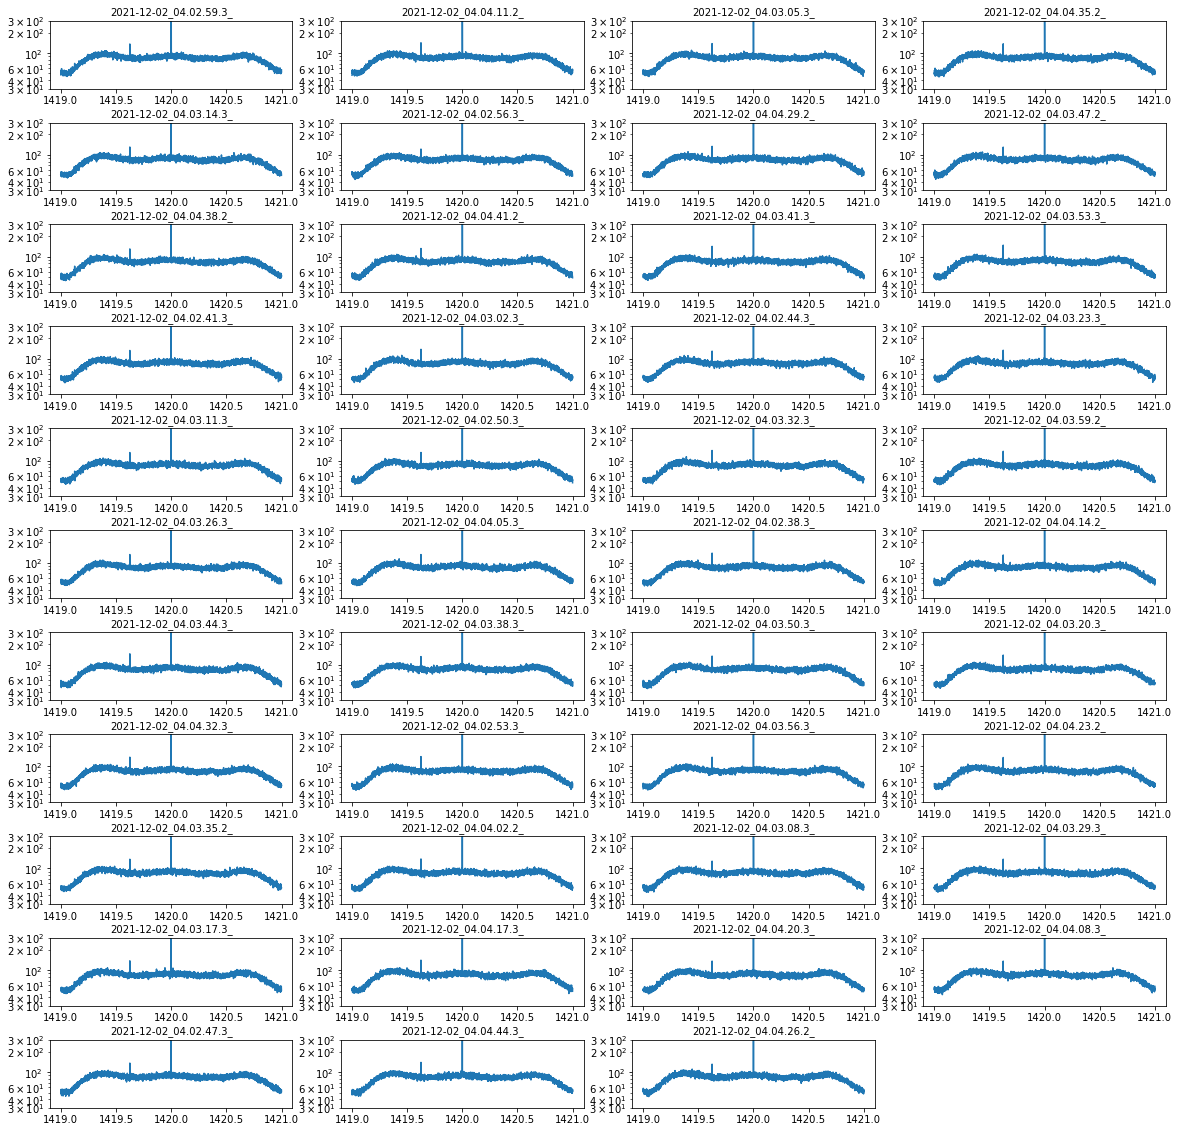

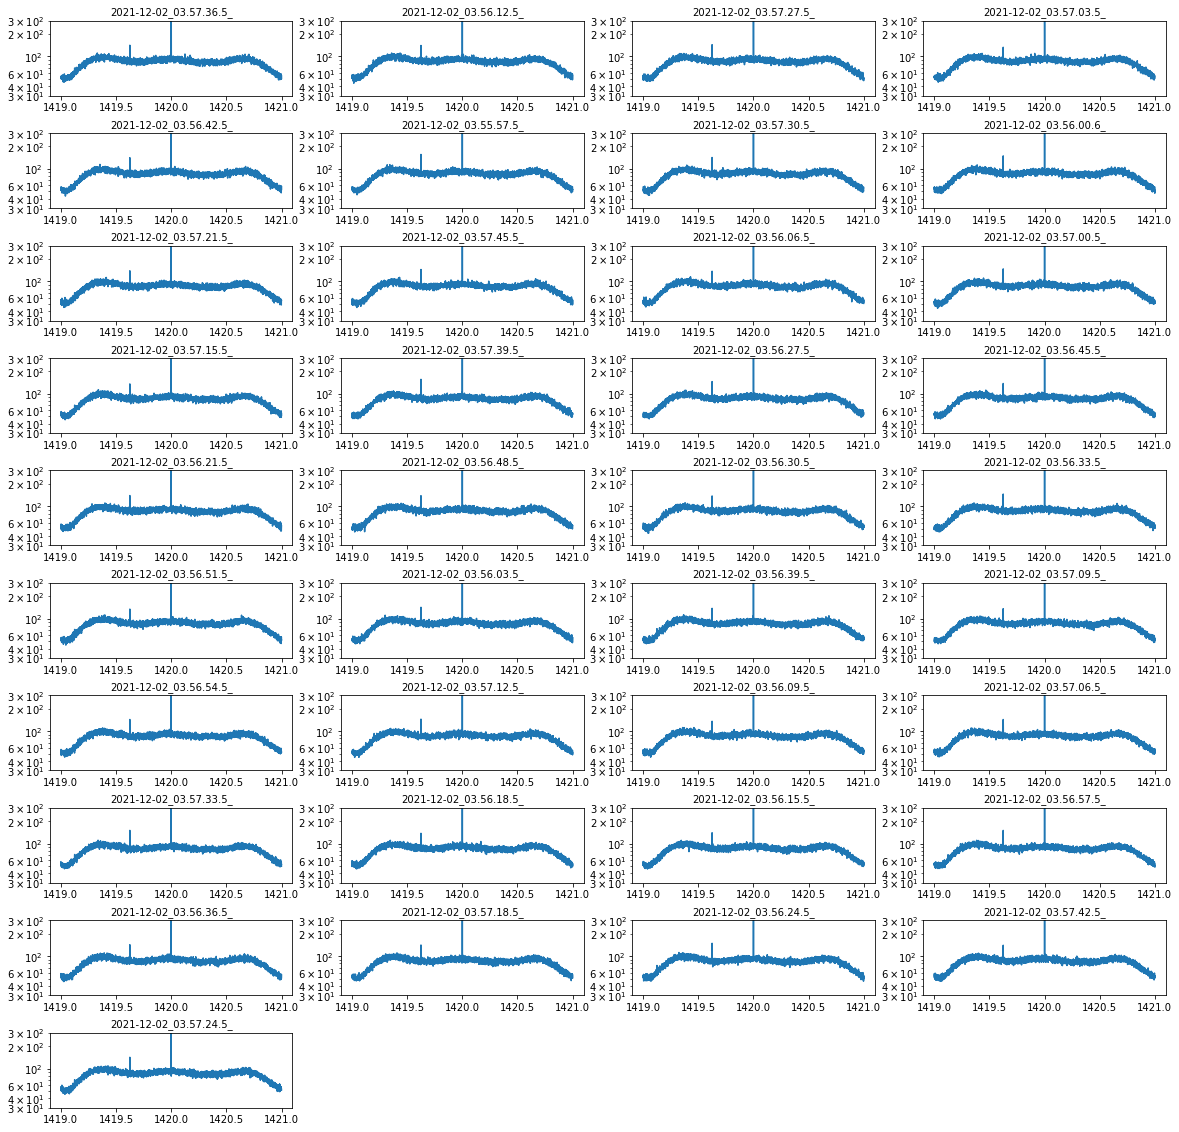

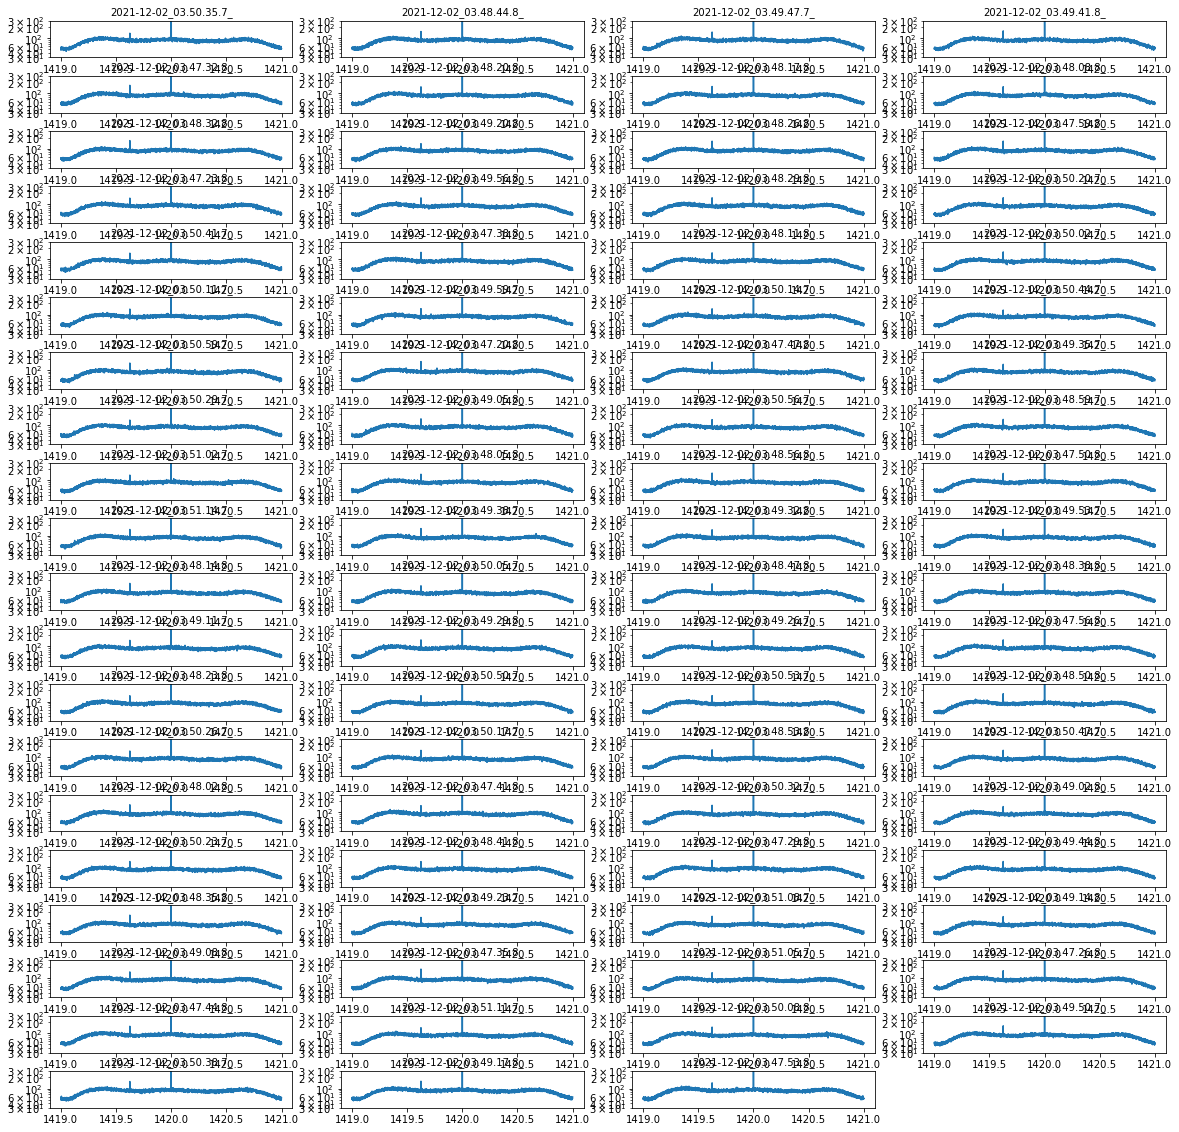

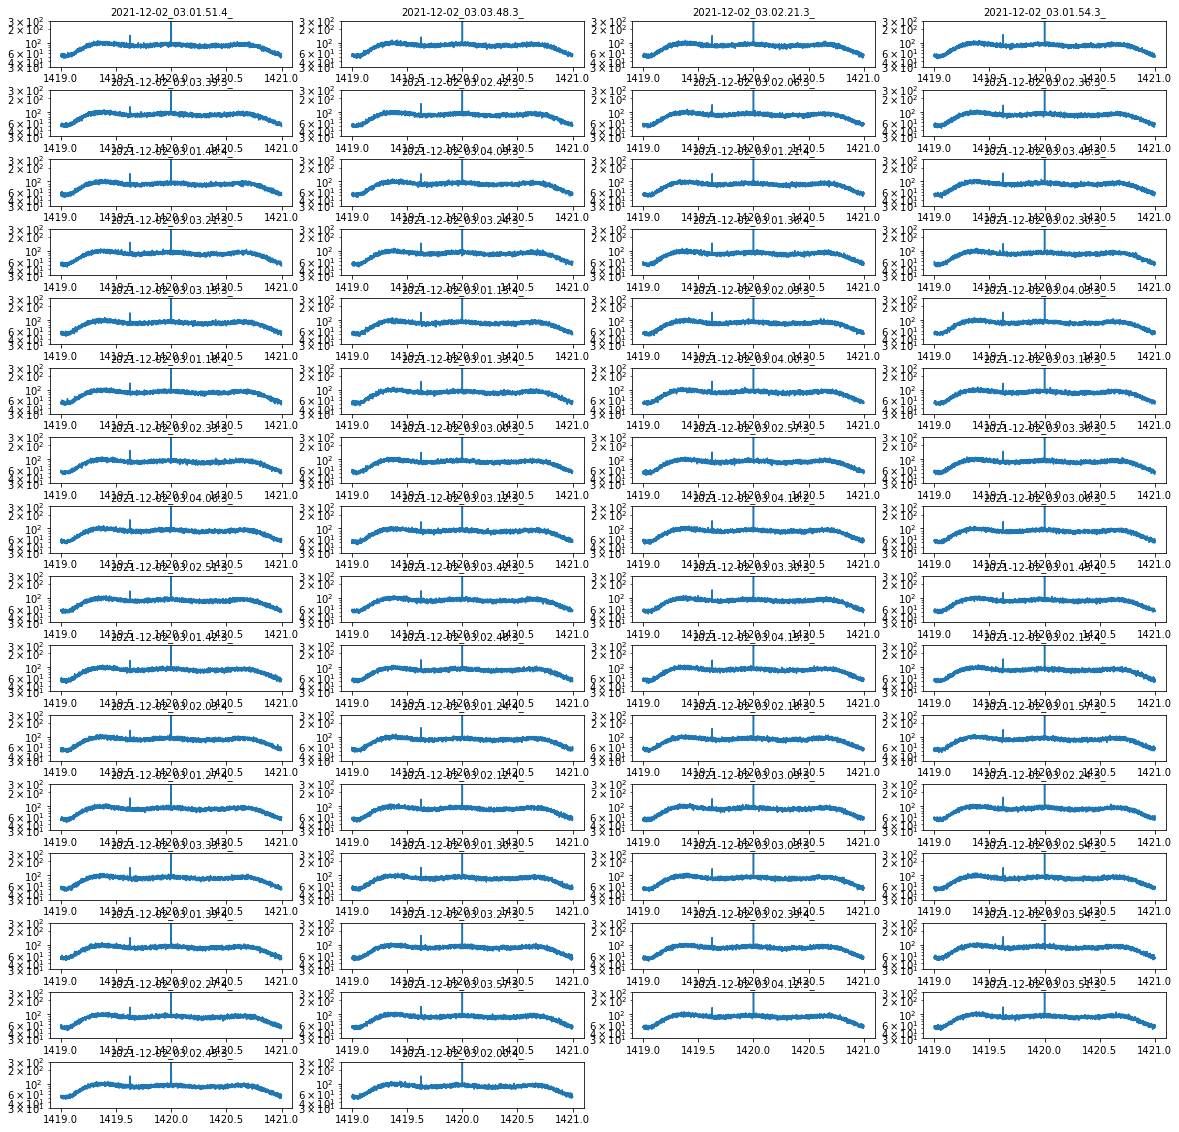

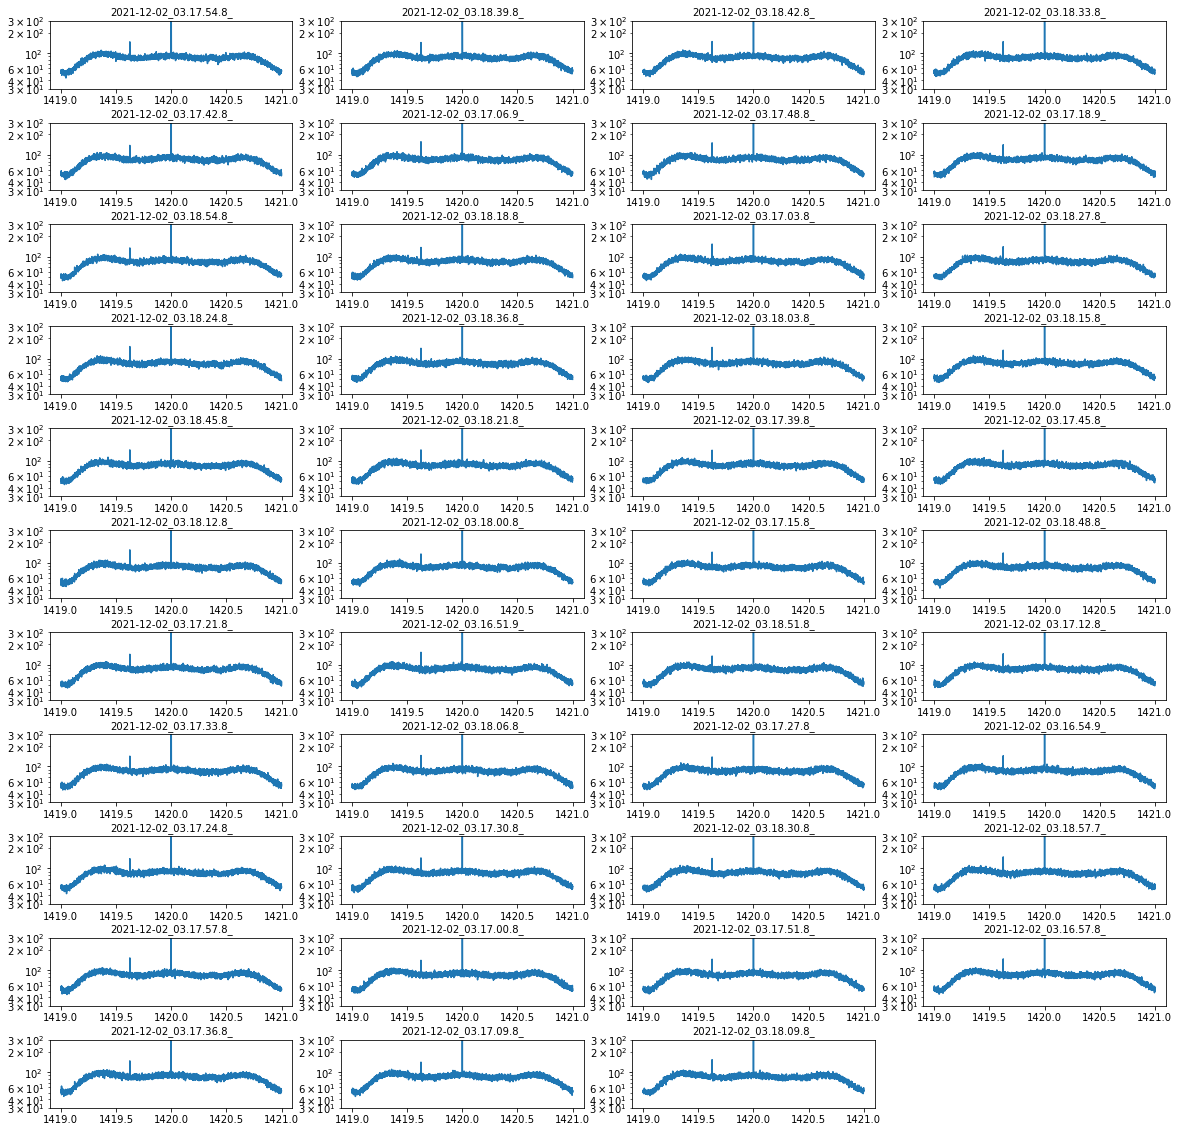

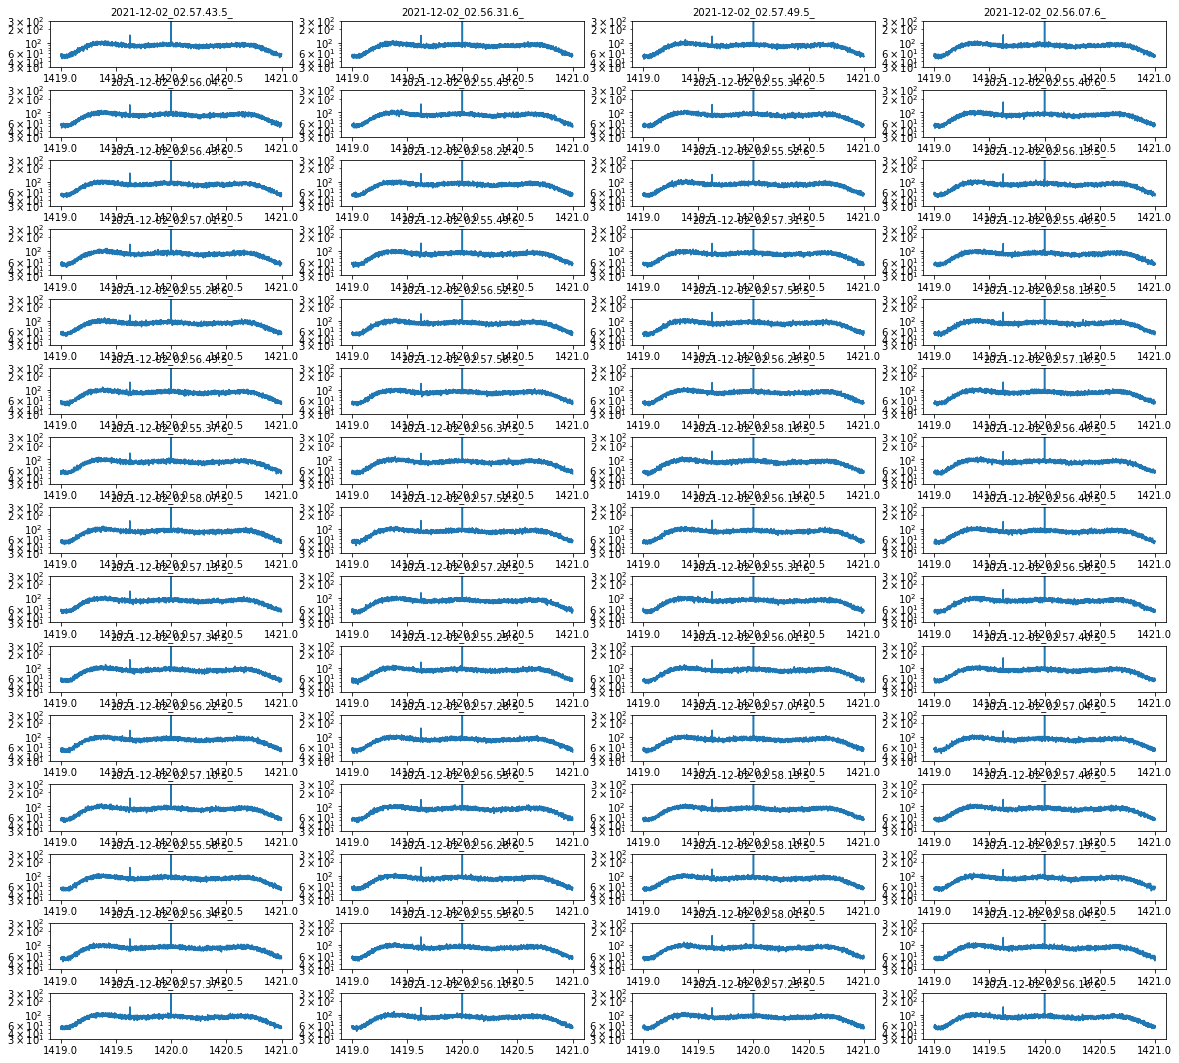

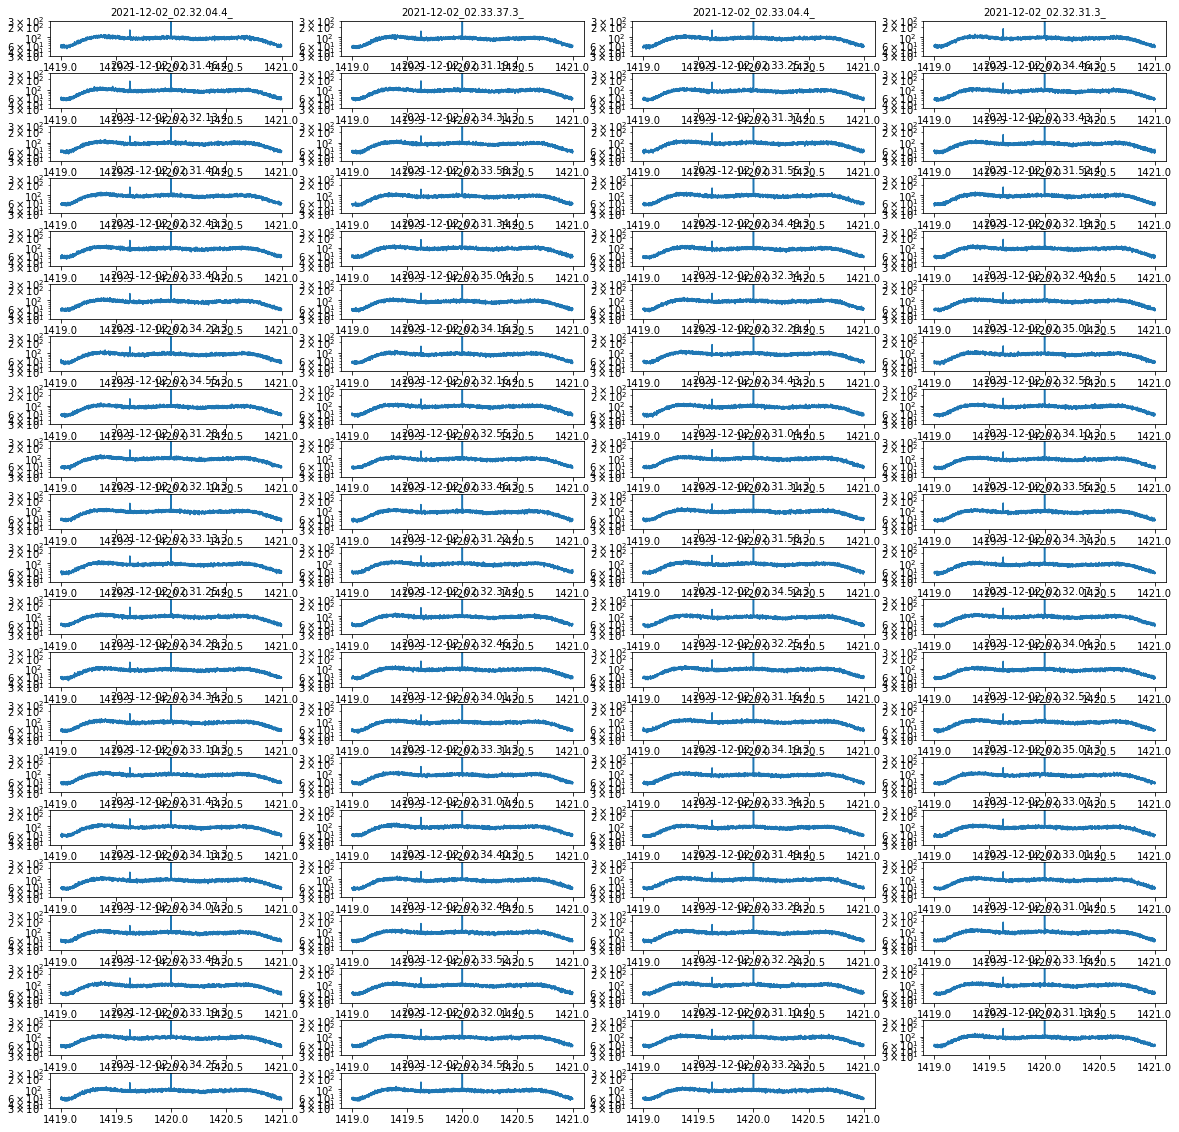

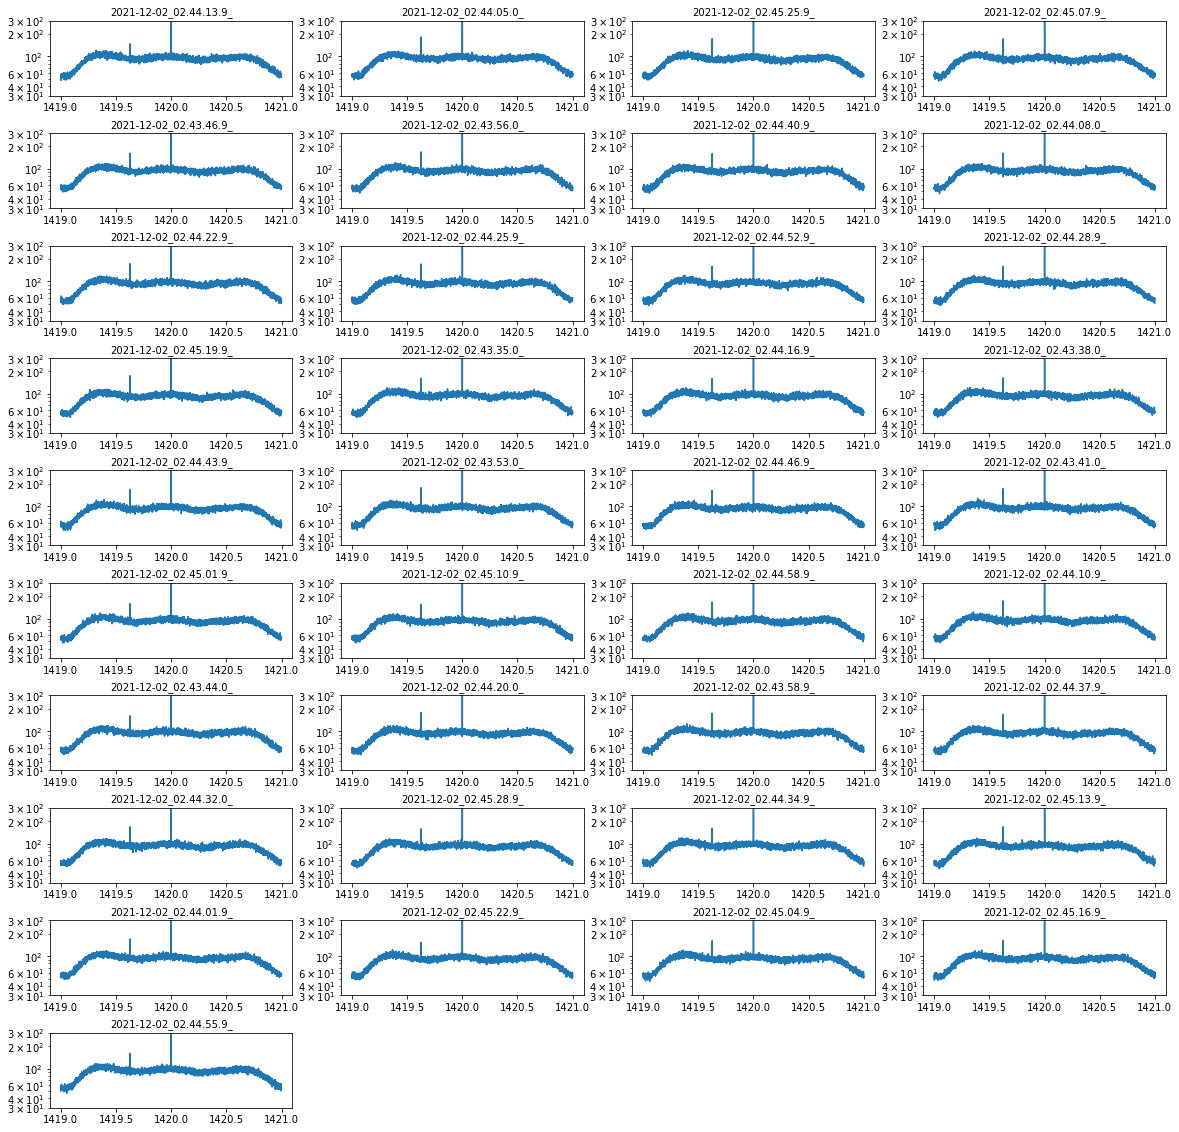

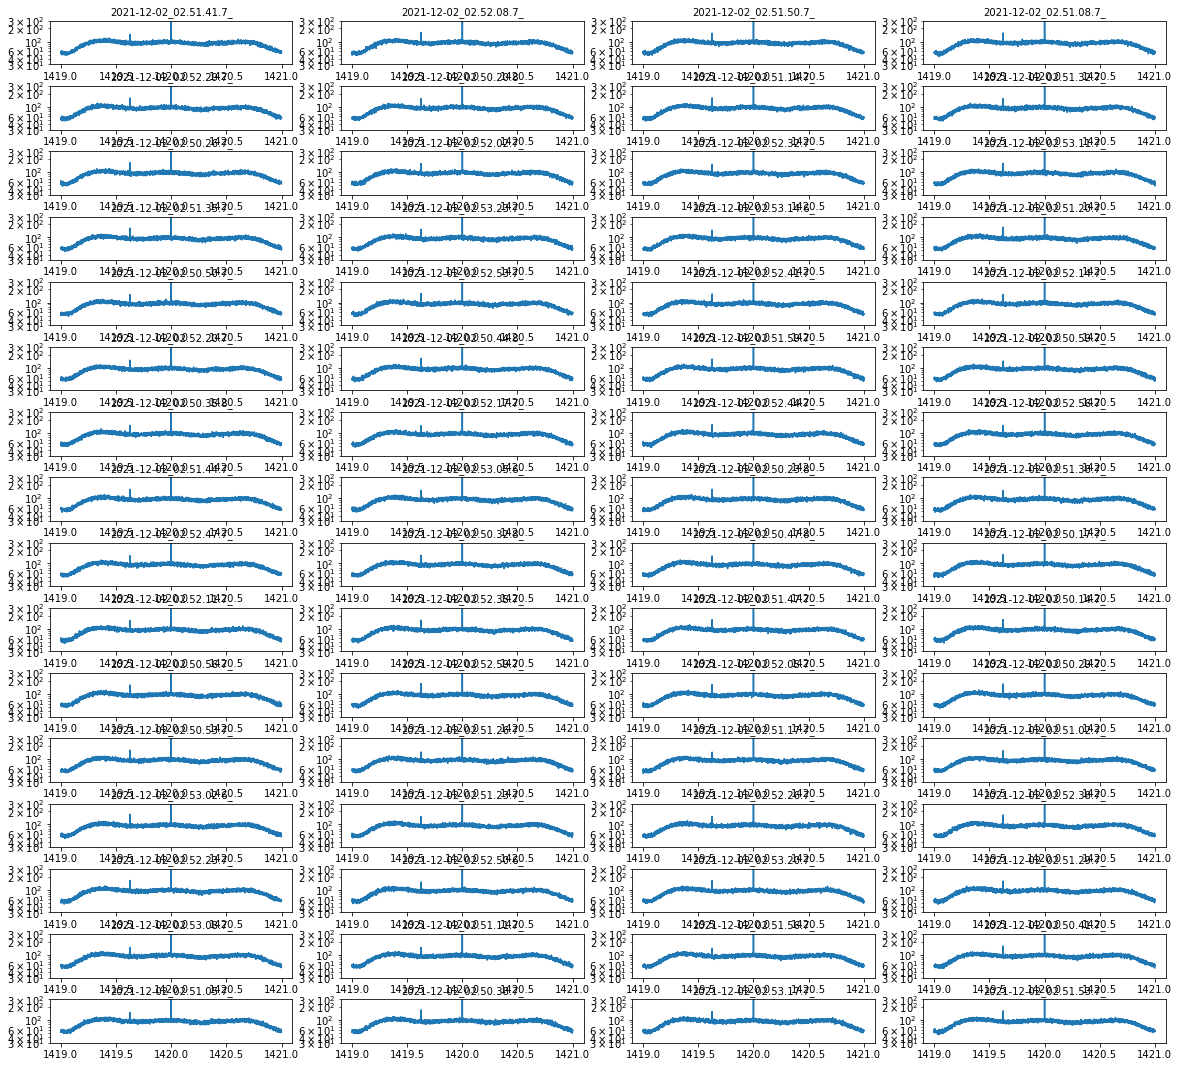

In [30]:
# loop through the spectra, average each longitude, flatten, and write out

# turn off inline plots for now
plt.ioff()

for f in filelist:
    if f[0:4] == 'long':
        d,n = inspect(f)
        print('Found {0} spectra in {1}'.format(n, d))
        print('Creating spectral plot')
        
        flat_subdir = 'flat'
        flat_dir = cwd + '/' + flat_subdir
        if not os.path.isdir(flat_dir):
            print('Creating subdirectory', flat_subdir, ' in ', cwd)
            os.mkdir(flat_dir)

        v, Cf = calibrate(f)
        ff = f+'_flat.csv'
        print('Writing flattened spectrum to ', ff)
        with open(flat_dir + '/' + ff, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(zip(v[::-1], Cf[::-1]))

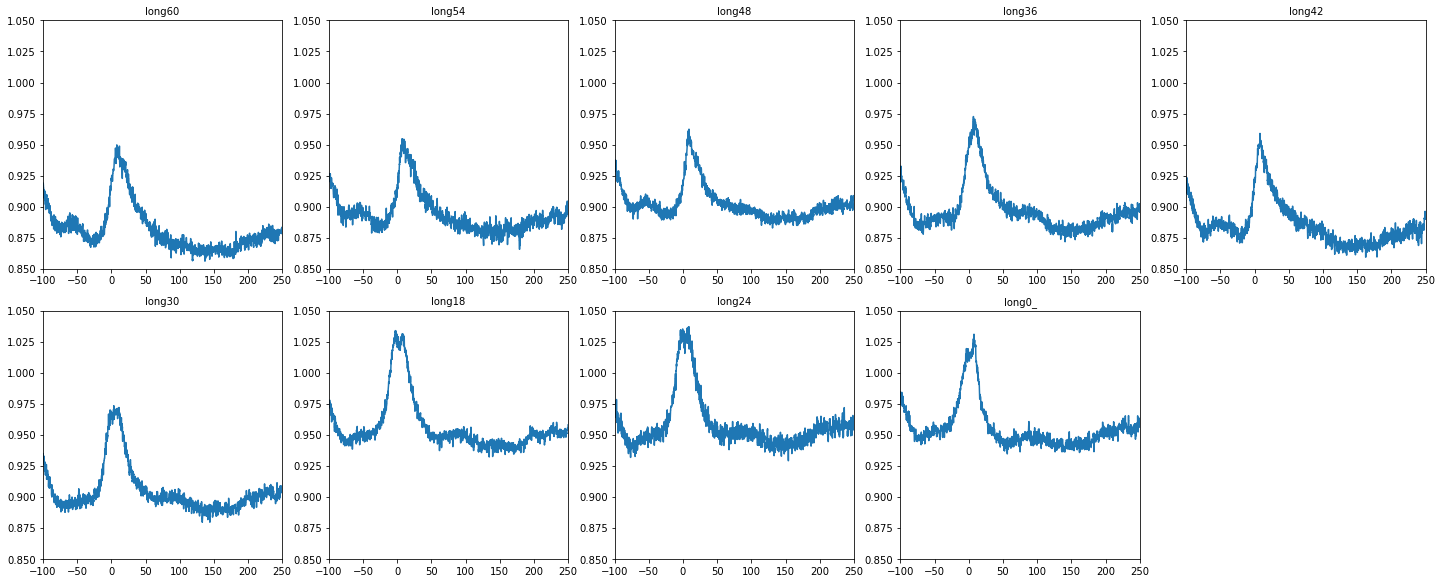

In [31]:
# look at the flattened spectra
# and determine the velocity range for doing the next (baseline) step
plt.ion()
files = glob.glob('flat/*.csv')
nfiles = len(files)
fig = plt.figure(figsize=(20,12))
ny = 5
nx = nfiles/4 + 1

for n,f in enumerate(files):
    v, Cf = np.genfromtxt(f, delimiter=',', unpack=True)
    ax = fig.add_subplot(int(nx), int(ny), int(n+1))
    ax.plot(v, Cf)
    label = f.split('/')[1][:6]
    ax.set_title(label, fontsize=10)
    ax.set_xlim(-100,250)
    ax.set_ylim(0.85,1.05)
plt.tight_layout()
plt.savefig('flattened_spectra.png')